In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import date_format
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import expr
from datetime import timedelta

In [ ]:
# start session
spark = SparkSession.builder.appName("HealthcareForecasting").getOrCreate()

# load CSV
df = pd.read_csv("cleaned_healthcare_data.csv")
df["Visit DateTime"] = pd.to_datetime(df["Visit DateTime"])
df["Month"] = df["Visit DateTime"].dt.to_period("M").astype(str)

# aggregate to monthly counts
monthly_df = df.groupby("Month").size().reset_index(name="Test Volume")
monthly_df["Month"] = pd.to_datetime(monthly_df["Month"])
monthly_df["Month_Num"] = range(len(monthly_df))

# convert to spark df
sdf = spark.createDataFrame(monthly_df)

In [ ]:
# feature vector from Month_Num
assembler = VectorAssembler(inputCols=["Month_Num"], outputCol="features")
sdf_features = assembler.transform(sdf).select("Month", "Month_Num", "Test Volume", "features")


In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="Test Volume")
lr_model = lr.fit(sdf_features)

In [ ]:
# last known month
last_month = monthly_df["Month"].max()

# 6 future months
future_dates = pd.date_range(start=last_month + pd.offsets.MonthBegin(1), periods=6, freq="MS")
future_month_nums = list(range(len(monthly_df), len(monthly_df) + 6))

# future DataFrame
future_pd = pd.DataFrame({
    "Month_Num": future_month_nums,
    "Month": future_dates
})

# Convert to Spark DataFrame
future_sdf = spark.createDataFrame(future_pd)
future_sdf = assembler.transform(future_sdf)

In [ ]:
future_preds = lr_model.transform(future_sdf)
predictions_df = future_preds.select("Month", "prediction").toPandas()

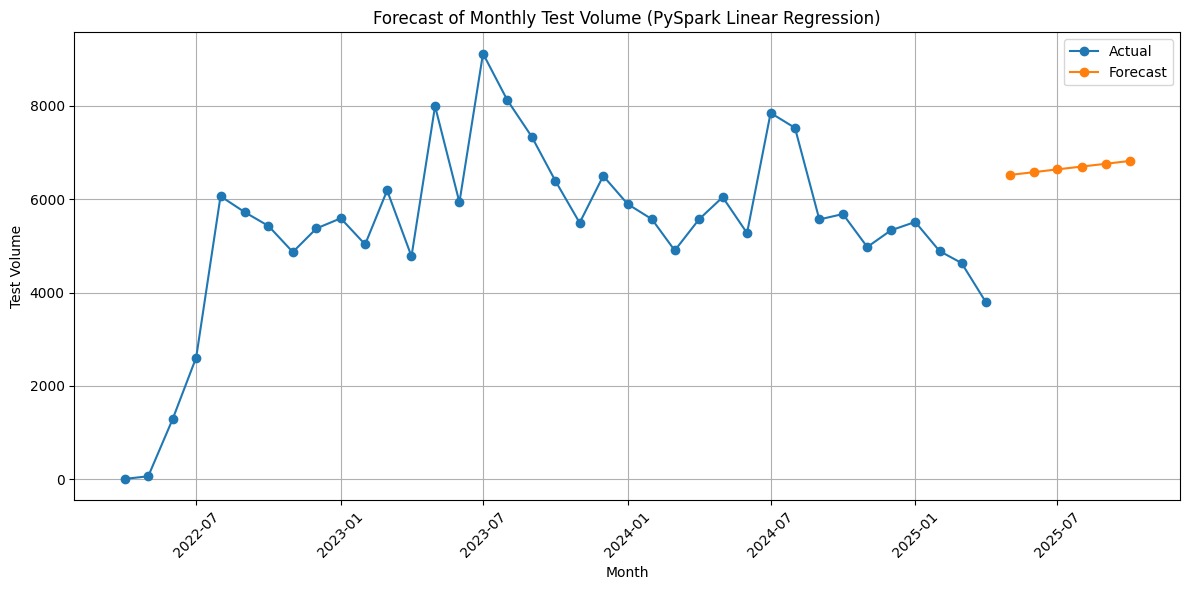

In [ ]:
import matplotlib.pyplot as plt

#actual data
actual_df = monthly_df[["Month", "Test Volume"]].copy()
actual_df["Source"] = "Actual"

#forecasted data
predictions_df.columns = ["Month", "Test Volume"]
predictions_df["Source"] = "Forecast"

#combine and plot
combined_df = pd.concat([actual_df, predictions_df])

plt.figure(figsize=(12, 6))
for label, group in combined_df.groupby("Source"):
    plt.plot(group["Month"], group["Test Volume"], marker='o', label=label)

plt.title("Forecast of Monthly Test Volume (PySpark Linear Regression)")
plt.xlabel("Month")
plt.ylabel("Test Volume")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

ARIMA (Not PySpark ML but was done as backup)

In [ ]:
!pip install statsmodels

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df = pd.read_csv("cleaned_healthcare_data.csv")
df["Visit DateTime"] = pd.to_datetime(df["Visit DateTime"])


df["Month"] = df["Visit DateTime"].dt.to_period("M").astype(str)
monthly_counts = df.groupby("Month").size().reset_index(name="Test Volume")
monthly_counts["Month"] = pd.to_datetime(monthly_counts["Month"])
monthly_counts = monthly_counts.sort_values("Month")

ts = monthly_counts.set_index("Month")["Test Volume"]


In [ ]:
# Fit
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

# forecast next 6 months
forecast_result = model_fit.get_forecast(steps=6)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#forecast DataFrame
future_dates = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq="MS")
forecast_df = pd.DataFrame({
    "Month": future_dates,
    "Forecast": forecast,
    "Lower Bound": conf_int.iloc[:, 0].values,
    "Upper Bound": conf_int.iloc[:, 1].values
})


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


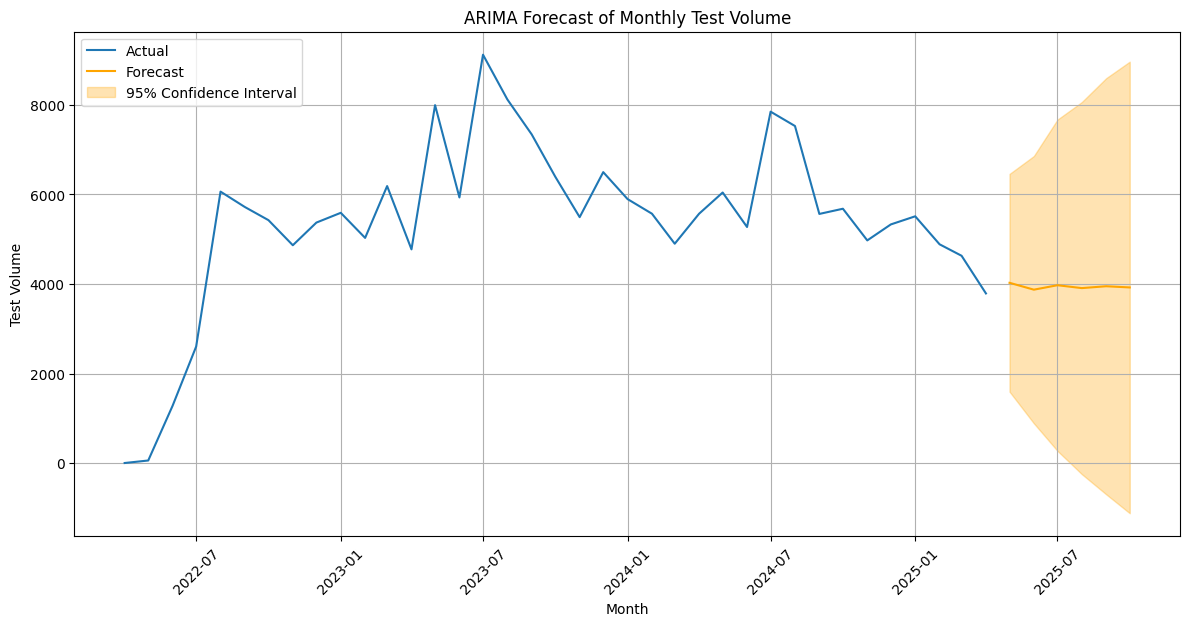

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts.values, label="Actual")
plt.plot(forecast_df["Month"], forecast_df["Forecast"], color="orange", label="Forecast")
plt.fill_between(forecast_df["Month"], forecast_df["Lower Bound"], forecast_df["Upper Bound"],
                 color="orange", alpha=0.3, label="95% Confidence Interval")

plt.title("ARIMA Forecast of Monthly Test Volume")
plt.xlabel("Month")
plt.ylabel("Test Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()